# Map Analysis II

###  Renée Hložek and Jeff McMahon

## Using our tools on real data

In this self study exercise, we are now going to use some public data from the ACT collaboration, compute power spectra and compare them to theory power spectra.

In [53]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits
%cd /Users/kushbanker/Desktop/Code/CMBAnalysis_SummerSchool
%matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = cs.atmospheric_noise_level
one_over_f_noise_level = cs.one_over_f_noise_level

/Users/kushbanker/Desktop/Code/CMBAnalysis_SummerSchool


# Reading in data and making simulated maps
Let's start by reading in a map and computing the power spectrum of the map, and then comparing to a theory map of a similar size/shape

0.49491833030853 0.49407681818181814
map mean: -3.5245380283448906 map rms: 311.228361194383


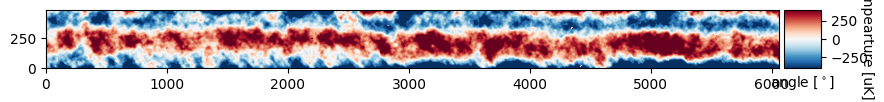

In [54]:
map = fits.getdata('/Users/kushbanker/Desktop/Code/CMBAnalysis_SummerSchool/ACT_Season3_148_GHz_submap.fits')
header = fits.getheader('/Users/kushbanker/Desktop/Code/CMBAnalysis_SummerSchool/ACT_Season3_148_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins
plt.figure(figsize=(10,10))
p = Plot_CMB_Map(map,c_min,c_max,Nx,Ny)


You can see that these ACT maps are long stripes, so we will cut a square patch out of the long strip and compute the PS on that patch.

In [55]:
N=int(Ny) # take only one dimension
map_patch = map[0:int(N), 0:int(N)] #trimming the map down to size


map mean: 20.125159755016572 map rms: 124.47878213360549


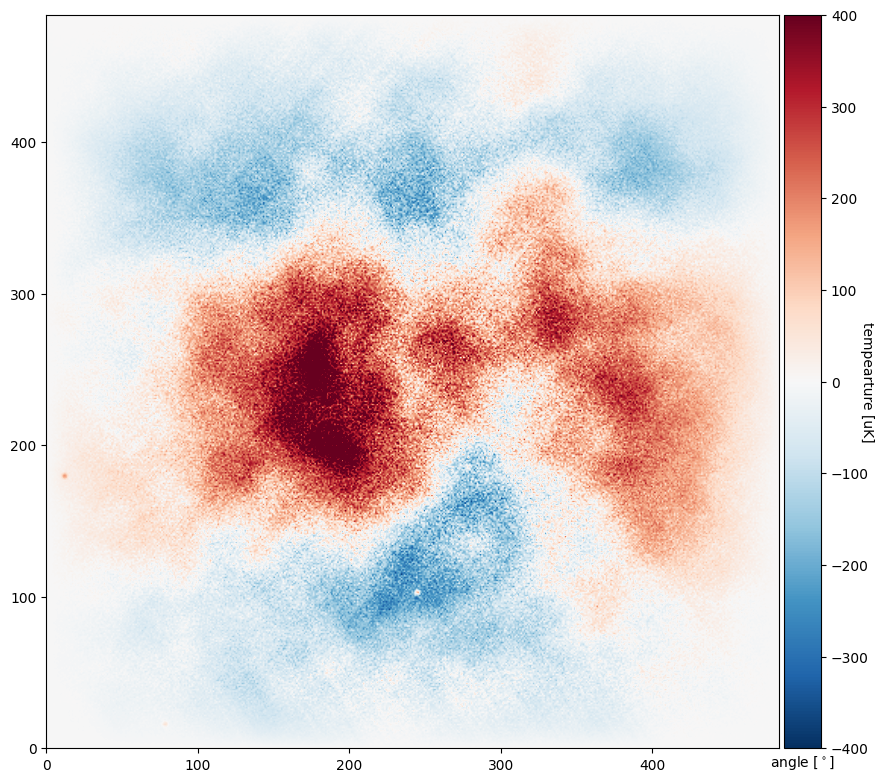

In [56]:
# Making a window function, taking the shorter dimension for now
window = (cosine_window(N))
appodized_map = window * map_patch
appodized_map_original = appodized_map
p=Plot_CMB_Map(appodized_map,c_min,c_max,N, N)


### We can see that there is a lot of power on large scales from the atmosphere. What do we expect to see in the power spectrum?

Number of sources required:  5000
map mean: -0.5611214647253292 map rms: 63.712832009605954


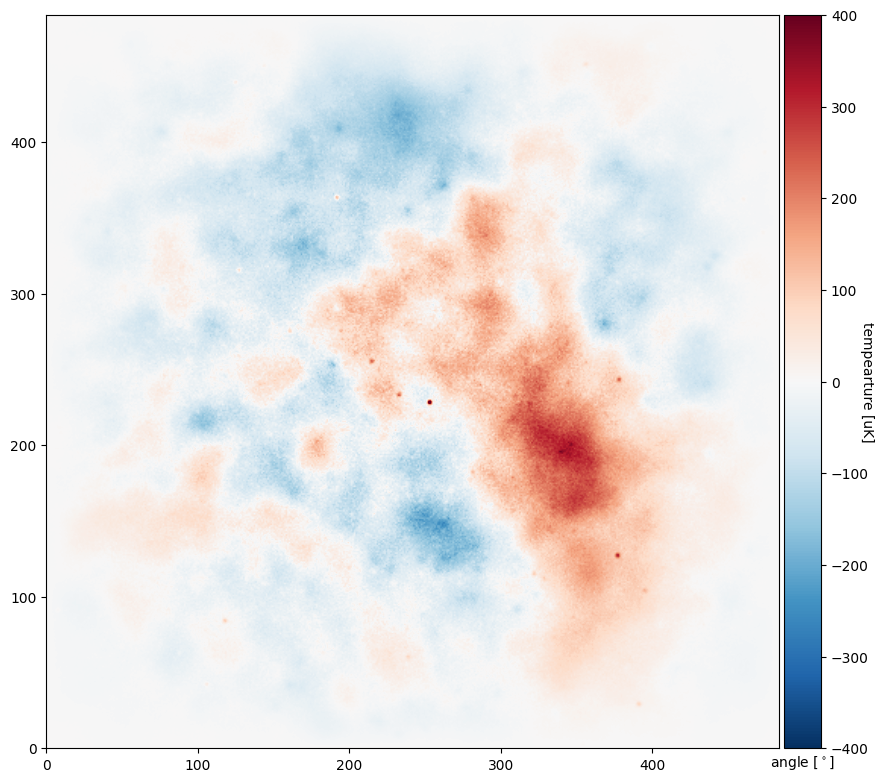

In [57]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 

CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorperate the impact of the instrument
    ## beam
CMB_T_convolved =convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

## plot the result
#p=Plot_CMB_Map(total_map_plus_noise,c_min,c_max,N,N)

appodized_theory_map = window * total_map_plus_noise

p=Plot_CMB_Map(appodized_theory_map,c_min,c_max,N, N)

## We will now take the power spectrum of this apodised map, and the theory version

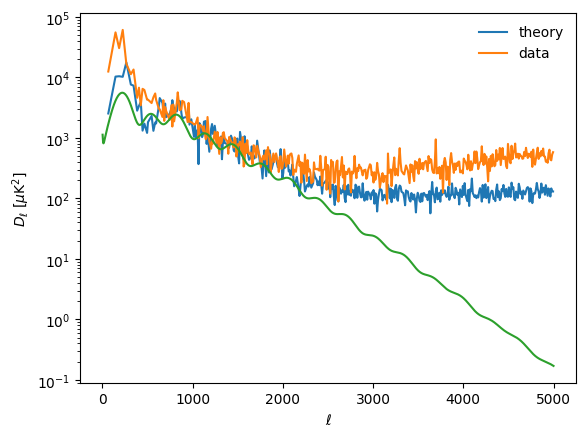

In [58]:
#### parameters for setting up the spectrum
delta_ell = 10# cs.delta_ell
ell_max = cs.ell_max
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')
        
binned_ell_theory, binned_spectrum_theory = \
    calculate_2d_spectrum(appodized_theory_map,delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    calculate_2d_spectrum(appodized_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='theory')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='data')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

Notice that the power spectrum is biased high on large scales - as we expected it to be.
How might you remove that large scale power before computing the power spectrum?
<font color='red'>EXCERCISE: </font>  Write code to filter out the large scale modes ell < ell_min before computing the power spectrum and show the spectra for a few different values for ell_min. Also, can you think about how to remove the ringing the power on small scales? Discuss the shape of the apodising window and the large scale power leaking to small scales.

Answer, Im trying to filter to remove the noise & filter out large scale modes, however the way im filtering is removig too much? It seems to come from the fftconvolution and i don't know why that is removing information ( or at least shifting modes from low frequency to high? when it should be conserving all modes other than those Im trying to filter

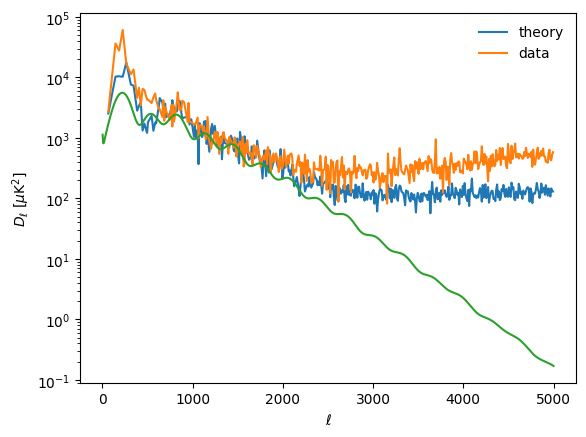

In [61]:
ell_min = 100

def Filter_Map2(Map, N, N_mask, ell_min):
    N = int(N)
    
    # set up a 2D ell coordinate system
    ones = np.ones(N)
    inds = (np.arange(N) + 0.5 - N/2.) / (N - 1.)
    kX = np.outer(ones, inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make a mask
    mask = np.ones([N, N])
    mask[np.where(ell2d < ell_min)] = 0
    
    # apply the filter in Fourier space
    FMap = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(Map)))
    FMap_filtered = FMap * mask
    Map_filtered = np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(FMap_filtered))))

    
    # return the output
    return Map_filtered

filtered_map = Filter_Map2(appodized_map, N, 10, ell_min)

binned_ell_dat_cut, binned_spectrum_dat_cut = \
    calculate_2d_spectrum(filtered_map,delta_ell,ell_max,pix_size,N)

#print(binned_ell_dat_cut, binned_spectrum_dat_cut)
#binned_ell_dat_cut = binned_ell_dat_cut[3:]
#binned_spectrum_dat_cut = binned_spectrum_dat_cut[3:]

#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='theory')
plt.semilogy(binned_ell_dat_cut,binned_spectrum_dat_cut*\
                binned_ell_dat_cut * (binned_ell_dat_cut+1.)/2. / np.pi, label='data')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

<font color='red'>EXCERCISE: </font>  We cut out a particular patch from the ACT strip. Cut out different patches and view them. By using the power spectrum code in the modules file, compute both the auto and the cross spectra for this map. Discuss how you would estimate the error bars on this power spectrum, by comparing the auto with the cross power spectra.

Add something here about how to take the cross-spectra maybe? (Look at nb4) cross-spectra involves 2d fft multiplied by complex conjugate of another 2d fft

map mean: 50.924744236328884 map rms: 129.4108141415959


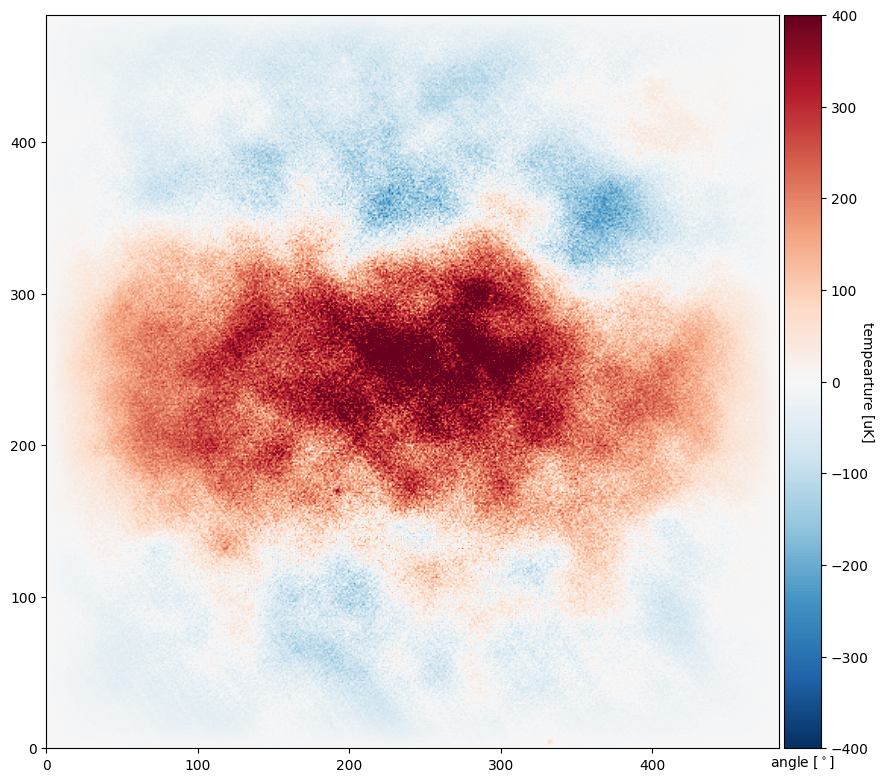

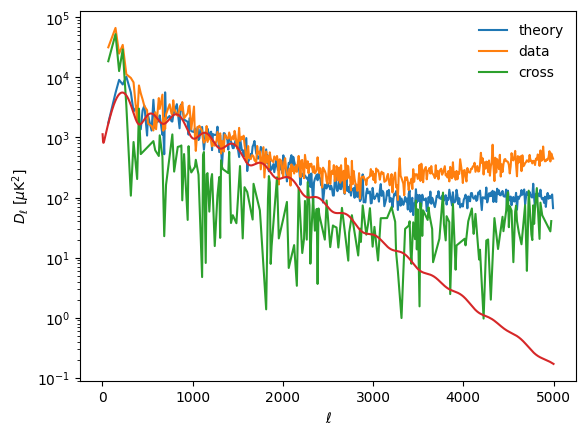

In [37]:
# Your code here
map_patch = map[0:int(N), 3 * N: 4* N] #trimming the map down to size
# Making a window function, taking the shorter dimension for now
window = (cosine_window(N))
appodized_map = window * map_patch
p=Plot_CMB_Map(appodized_map,c_min,c_max,N, N)

#Take the auto power spectra
binned_ell_dat2, binned_spectrum_dat2 = \
    calculate_2d_spectrum(appodized_map,delta_ell,ell_max,pix_size,N)

def calculate_2d_cross_spectrum(Map,Map2, delta_ell,ell_max,pix_size,N):
    "calculates the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    import matplotlib.pyplot as plt
    # make a 2d ell coordinate system
    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap = np.fft.ifft2(np.fft.fftshift(Map))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    
#    print FMap
    PSMap = np.fft.fftshift(np.real(FMap * np.conj(FMap2))) # multiplying by the conjugate
    #Plot_CMB_Map(np.real(np.fft.fft2(PSMap)),c_min,c_max,N, N)
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        i = i + 1


    CL_array_n = CL_array[~np.isnan(CL_array)]
    ell_array_n = ell_array[~np.isnan(CL_array)]
    
    #cut out neg values? does this make sense to do? (without this the power spectrum fluctuates wildly)
    CL_array_new = CL_array_n[CL_array_n > 0]
    ell_array_new = ell_array_n[CL_array_n > 0]
    # return the power spectrum and ell bins
    return(ell_array_new,CL_array_new*np.sqrt(pix_size /60.* np.pi/180.)*2.)

#cross power spectra
#which map should i use to get the cross spectra? I need another map with the same signal but diff noise?
c_ell, c_spectrum = calculate_2d_cross_spectrum(appodized_map_original,appodized_map,delta_ell,ell_max,pix_size,N)

plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='theory')
plt.semilogy(binned_ell_dat2,binned_spectrum_dat2*\
                binned_ell_dat2 * (binned_ell_dat2+1.)/2. / np.pi, label='data')
plt.semilogy(c_ell,c_spectrum*\
                c_ell * (c_ell+1.)/2. / np.pi, label='cross')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

<font color='red'>EXCERCISE: </font>  Given the value of the PS shown here on small scales, we can estimate the noise level in the ACT maps for this season. Plot noise curves for a few values and show here, and do a simple "chi-by-eye" fit for the noise level.

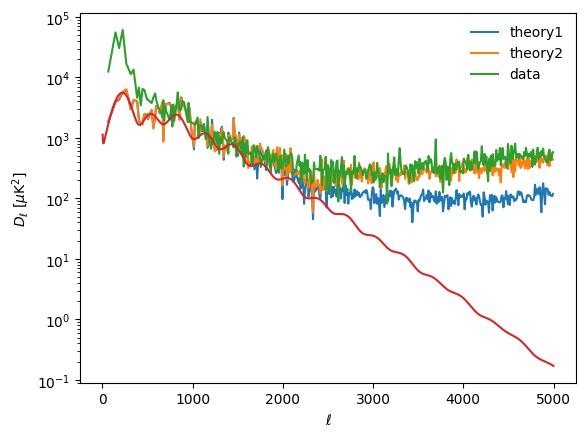

In [51]:
Noise1 = make_noise_map(N,pix_size,10,0.01,0.02)
Noise2 = make_noise_map(N,pix_size,30,0.01,0.02)

map_patch = map[0:int(N), 0:int(N)] #trimming the map down to size
# Making a window function, taking the shorter dimension for now
window = (cosine_window(N))
appodized_map = window * map_patch
appodized_theory_map1 = window * (CMB_T_convolved + Noise1)
appodized_theory_map2 = window * (CMB_T_convolved + Noise2)
#p=Plot_CMB_Map(appodized_map,c_min,c_max,N, N)

binned_ell_theory1, binned_spectrum_theory1 = \
    calculate_2d_spectrum(appodized_theory_map1,delta_ell,ell_max,pix_size,N)
binned_ell_theory2, binned_spectrum_theory2 = \
    calculate_2d_spectrum(appodized_theory_map2,delta_ell,ell_max,pix_size,N)

#Take the auto power spectra
binned_ell_dat, binned_spectrum_dat = \
    calculate_2d_spectrum(appodized_map,delta_ell,ell_max,pix_size,N)

plt.semilogy(binned_ell_theory1,binned_spectrum_theory1*\
                 binned_ell_theory1 * (binned_ell_theory1+1.)/2. / np.pi, label='theory1')
plt.semilogy(binned_ell_theory2,binned_spectrum_theory2*\
                 binned_ell_theory2 * (binned_ell_theory2+1.)/2. / np.pi, label='theory2')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='data')

leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

THe noise levels of white noise = 30, 1/f = 0.01, atmospherec 0.02

<font color='red'>EXCERCISE: </font>  Plot the 2D power spectrum, both of your input theory+ noise and the ACT data. What does that tell you about real-world noise from CMB Experiments?

In [ ]:
## Your code here

## Frequency dependence of maps and foregrounds

Now we are going to look at ACT maps on the same patch of the sky, but in a different frequency band.

0.49491833030853 0.49407681818181814
map mean: -35.148097186618045 map rms: 319.0813587167169


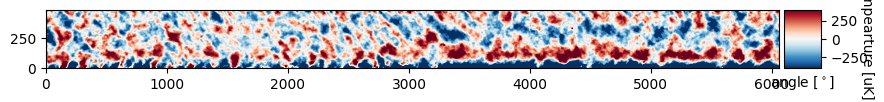

In [38]:
map220 = fits.getdata('ACT_Season3_220_GHz_submap.fits')
header = fits.getheader('ACT_Season3_220_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins
plt.figure(figsize=(10,10))
p = Plot_CMB_Map(map220,c_min,c_max,Nx,Ny)


50


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


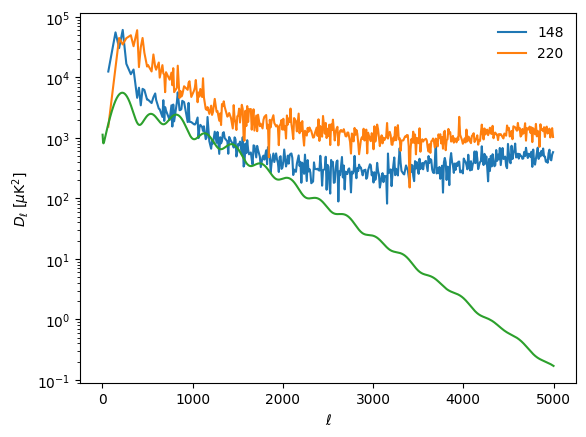

In [39]:
N=int(Ny) # take only one dimension
map_patch220 = map220[0:int(N), 0:int(N)] #trimming the map down to size
window = (cosine_window(N))
appodized_map220 = window * map_patch220
print(Mean_Amplitude_of_SZ_Clusters)

binned_ell_dat220, binned_spectrum_dat220 = calculate_2d_spectrum(appodized_map220,delta_ell,ell_max,pix_size,N)
plt.semilogy(binned_ell_dat,binned_spectrum_dat* binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='148')
plt.semilogy(binned_ell_dat220,binned_spectrum_dat220* binned_ell_dat220 * (binned_ell_dat220+1.)/2. / np.pi, label='220')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

<font color='red'>EXCERCISE: </font> The spectrum is biased high from point sources on all scales. Use the code from the previous notebook to determine the noise bias for this spectrum and remove it.

In [41]:
## construct the 2d noise noise covariance in fourier space
FT_noise_covar = np.zeros((N,N))  ## a 2d array to hold the result
     
N_iterations = 32

print("Starting")

## make a series of simulated maps, find the power spectrum, and average these to esitmae the noise covariance
i = 0
while (i <N_iterations):
    ## sumilate the astrophysical map
    CMB_T = make_CMB_T_map(N,pix_size,binned_ell_dat220,binned_spectrum_dat220)
    PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
    PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)
    SZMap,trash = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)
    CMB_T  = CMB_T + PSMap + SZMap  ## the astrophysical map
    
    ## fold in the instrument response
    CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,CMB_T)
    Noise = make_noise_map(N,pix_size,30,0.01,0.02)
    
    ## fourier trasfomr the map
    temp =  np.fft.fft2(np.fft.fftshift(window* (CMB_T_convolved + Noise)))  ## these are the two terms in the denominator

    ## now average
    FT_noise_covar += np.real(np.conj(temp)*temp/(N_iterations*1.0))
    ## note the progress
    sys.stdout.write("\r matched filter noise realization, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    ## iterate
    i = i + 1

Starting
Number of sources required:  5000
 matched filter noise realization, iterations complete: 1 of 32Number of sources required:  5000
 matched filter noise realization, iterations complete: 2 of 32Number of sources required:  5000
 matched filter noise realization, iterations complete: 3 of 32Number of sources required:  5000
 matched filter noise realization, iterations complete: 4 of 32Number of sources required:  5000
 matched filter noise realization, iterations complete: 5 of 32Number of sources required:  5000
 matched filter noise realization, iterations complete: 6 of 32Number of sources required:  5000
 matched filter noise realization, iterations complete: 7 of 32Number of sources required:  5000
 matched filter noise realization, iterations complete: 8 of 32Number of sources required:  5000
 matched filter noise realization, iterations complete: 9 of 32Number of sources required:  5000
 matched filter noise realization, iterations complete: 10 of 32Number of sources re

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


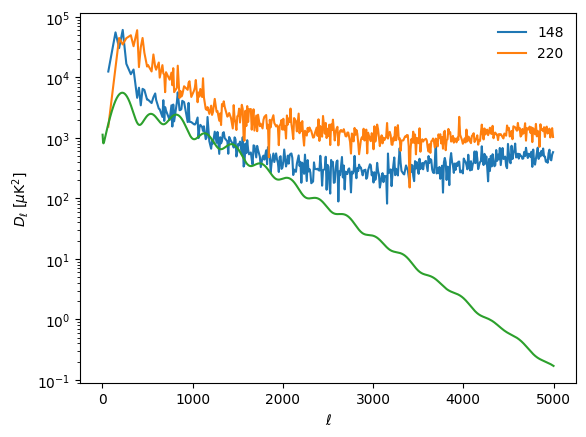

In [42]:
binned_ell_dat220_n, binned_spectrum_dat220_n = calculate_2d_spectrum(appodized_map220,delta_ell,ell_max,pix_size,N)
plt.semilogy(binned_ell_dat,binned_spectrum_dat* binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='148')
plt.semilogy(binned_ell_dat220_n,binned_spectrum_dat220_n* binned_ell_dat220_n * (binned_ell_dat220_n+1.)/2. / np.pi, label='220')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

In [14]:
def matched_filter(input_map,beam_and_filt,signal_profile,FT_noise_covar):
    ## input_map: the map we are processing
    ## beam_and_filt: the beam convolved with any map filtering, in real space
    ## signal_profile: the shape of the signal we are looking for, in real spcae
    ## FT_noise_covar: the B_N_{ap}^2 + N_{ins}^2 in fourier space
             ## calculating FT_npoise_covar is expensive so it is done externally
        
    FT_beam_and_filt = np.fft.fft2(np.fft.fftshift(beam_and_filt))  ## tranform beam_and_filt to fourier space
    FT_signal = np.fft.fft2(np.fft.fftshift(signal_profile))       ## tranform cluster_profile to fourier space
    
    psi = FT_beam_and_filt * FT_signal / FT_noise_covar             ## define the matchedfilter funciton
    
    filtered = psi * np.fft.fft2(np.fft.fftshift(input_map))        ## filter the map
    filtered = np.fft.fftshift(np.fft.ifft2(filtered))              ## center the filter
    filtered = np.real(filtered)                                    ## change the data type to real
    return(filtered)


def Plot_Matched_Filtered_Map(Map_to_Plot,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.figure(figsize=[10,10])
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    #im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('matched_filter [S/N]', rotation=270)
    plt.show()
    return(0)
  ###############################
def delta_function(N, intensity):
    func_map = np.zeros((N,N))
    func_map[N//2, N//2] = intensity
    return func_map

map mean: -2.48568345391803 map rms: 125.8365496372448


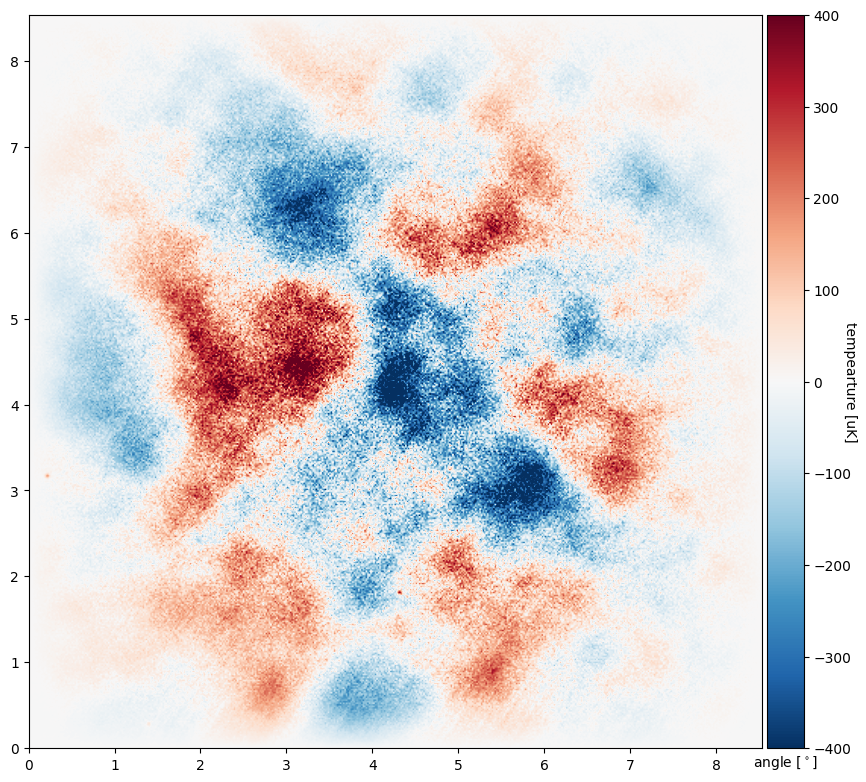

map mean: -4.718617235349647e-05 map rms: 0.9999999999999999


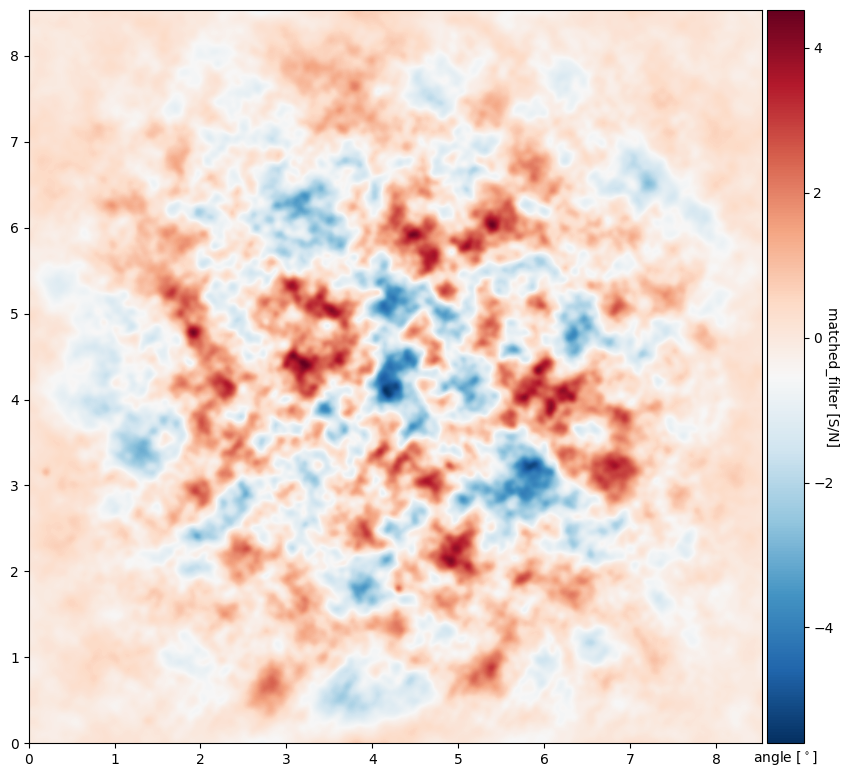

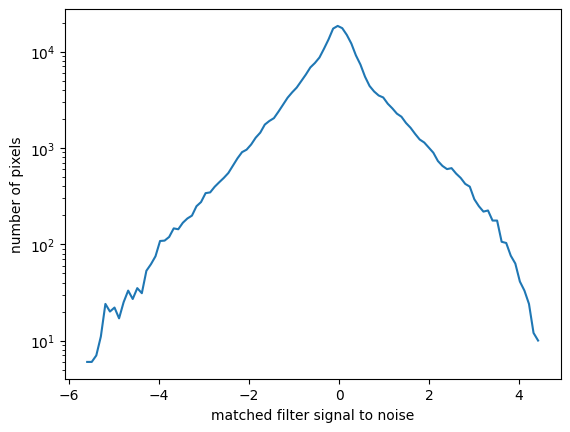

In [43]:
cluster_profile = beta_function(N,pix_size,SZ_beta,SZ_Theta_core)
beam_and_filt = make_2d_gaussian_beam(N,pix_size,beam_size_fwhp)


## Apply the matched filter to our map
filtered_map = matched_filter(appodized_map220,beam_and_filt,cluster_profile,FT_noise_covar)

## make a S/N map
SN_map = filtered_map / np.std(filtered_map)

## make a few plots
p = Plot_CMB_Map(appodized_map220,c_min,c_max,X_width,Y_width)
p = Plot_Matched_Filtered_Map(SN_map,X_width,Y_width)

hist,bin_edges = np.histogram(SN_map,bins = 100,range=[SN_map.min(),SN_map.max()])
plt.semilogy(bin_edges[0:-1],hist)
plt.ylabel('number of pixels')
plt.xlabel('matched filter signal to noise')
plt.show()

map mean: -2.48568345391803 map rms: 125.8365496372448


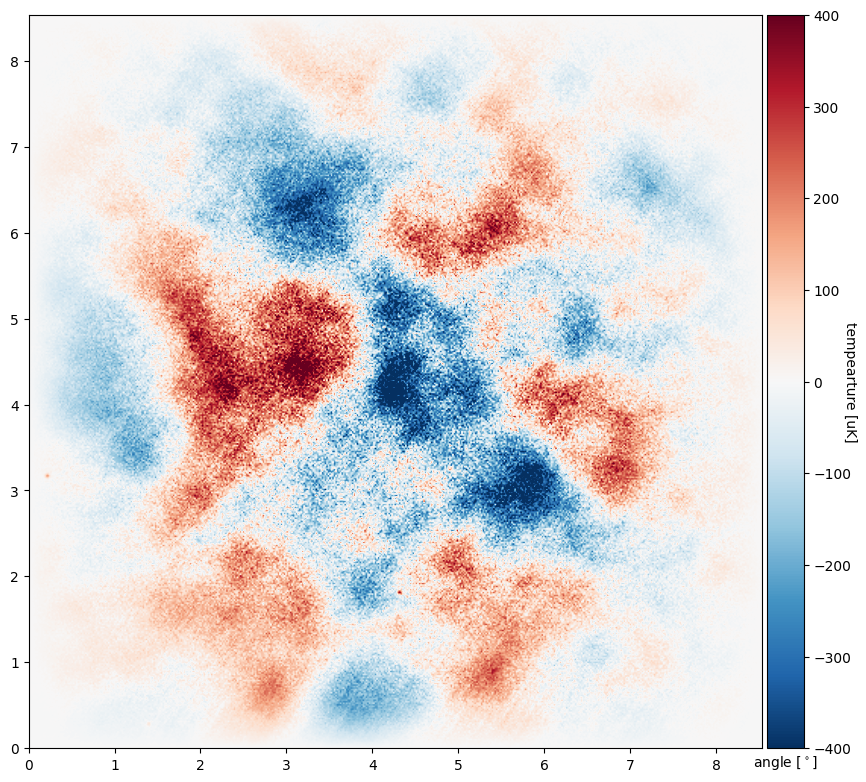

map mean: -2.7107029376673486e-06 map rms: 1.0


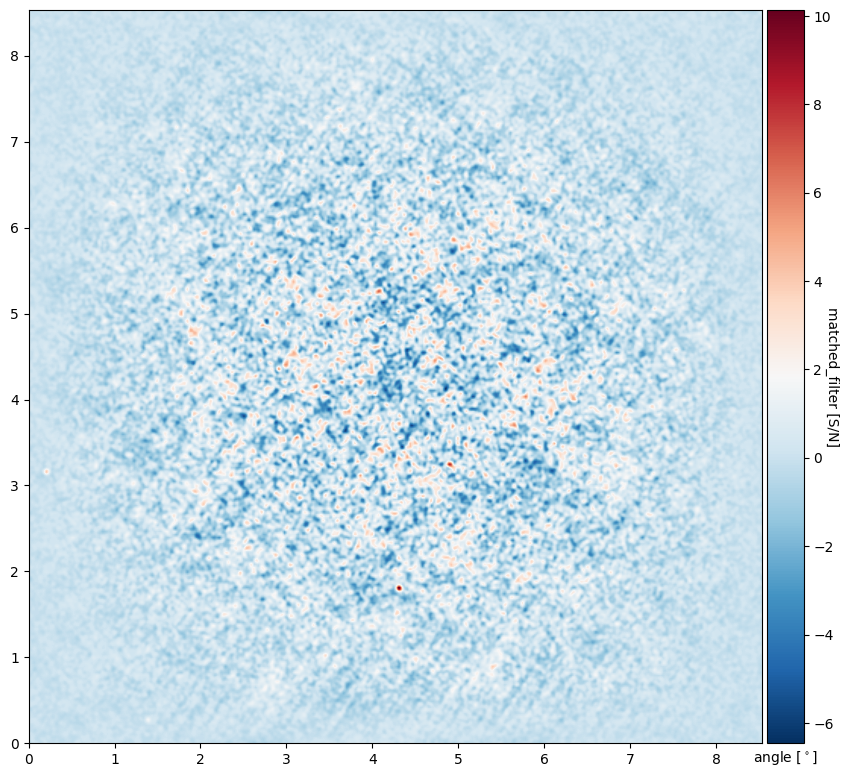

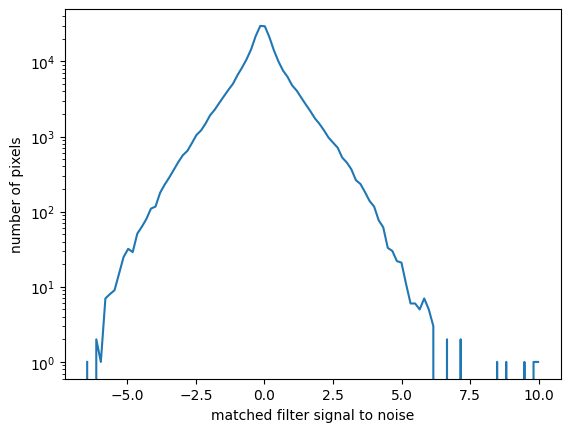

In [44]:
## construct the beam and cluster profile for the numerator of the matched filter
beam_and_filt = make_2d_gaussian_beam(N,pix_size,beam_size_fwhp)  ## this is the filtering we did on the map
cluster_profile = delta_function(N,100) ## this is the singnal we are looking for


## Apply the matched filter to our map
filtered_map = matched_filter(appodized_map220,beam_and_filt,cluster_profile,FT_noise_covar)

## make a S/N map
SN_map = filtered_map / np.std(filtered_map)

## make a few plots
p = Plot_CMB_Map(appodized_map220,c_min,c_max,X_width,Y_width)
p = Plot_Matched_Filtered_Map(SN_map,X_width,Y_width)

hist,bin_edges = np.histogram(SN_map,bins = 100,range=[SN_map.min(),SN_map.max()])
plt.semilogy(bin_edges[0:-1],hist)
plt.ylabel('number of pixels')
plt.xlabel('matched filter signal to noise')
plt.show()

<font color='red'>EXCERCISE: </font> Apply the techniques from Part Five and search for point sources and SZ clusters in the map

starting extraction
maps made


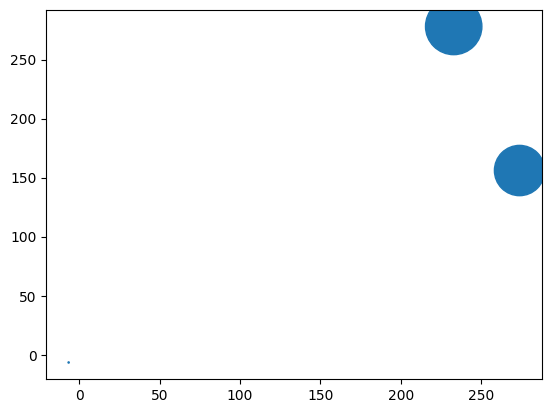

In [21]:
SN_map_cur = SN_map.copy()
cat = []
amp = SN_map_cur.min()
print("starting extraction")
i = 0
while(amp < -4):
    idx = SN_map_cur.argmin()
    idx = np.unravel_index(idx, SN_map_cur.shape)
    R = 5 # radius to set to 0
    if idx[0] <= R:
        SN_map_cur[0:idx[0]+R, idx[1]-R: idx[1]+R] = 0
    elif idx[1] <= R:
        SN_map_cur[idx[0]-R:idx[0]+R, 0: idx[1]+R] = 0
    else:
        SN_map_cur[idx[0]-R:idx[0]+R, idx[1]-R: idx[1]+R] = 0
    cat.append((idx[0], idx[1], amp))
    amp = SN_map_cur.min()
    i += 1
    #print(idx)
cat = np.array(cat)

def make_map(cat, N):
    map_arr = np.zeros((N,N))
    for point in cat:
        x = int(point[0])
        y = int(point[1])
        map_arr[x, y] = point[2]
    return map_arr
#print(detected_map[])
#detected_map = make_map(cat, N)
#SZCat_map = make_map(SZCat, N)
print("maps made")
#Plot_CMB_Map(SZCat_map, X_width, Y_width)
#plt.scatter(SZCat[0], SZCat[1], s=(SZCat[2]**2)/50)
plt.scatter(cat[0], cat[1], s=(cat[2]**2)/50)